# Comparando Otsu e por Watershed


Vamos continuar a explorar técnicas de segmentação e entender que para conseguirmos uma boa segmentação, muitas vezes é preciso pré-processar as imagens (calcular o gradiente, por exemplo). Além disso, é preciso saber escolher o melhor valor para cada parâmetro do método, o que pode não ser trivial. Algumas técnicas são mais fáceis de usar, porém pode ter uma performance inferior. Outras podem ser superirores, porém com mais parâmetros de ajuste.

### Segmentação pelo método de Limiarização de Otsu

Para alguns problemas de segmentação, técnicas simples de limiarização podem ser suficientes. No exemplo a seguir, vamos tentar resolver a segmentação dos *cookies* pelo método de limiarização de Otsu, tanto global quanto local.

In [15]:
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline

from skimage import measure
from skimage.filters.rank import otsu
from skimage.filters import threshold_otsu, sobel

import skimage.morphology as mm
from skimage.segmentation import watershed, join_segmentations
from skimage.segmentation import mark_boundaries

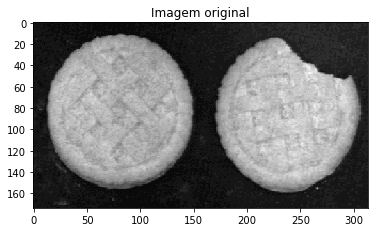

In [16]:
f_pil = Image.open('../figures/cookies.pgm')
f = np.array(f_pil)
plt.imshow(f, cmap='gray')
plt.title('Imagem original')

Vamos agora tentar segmentar os *cookies*, ou seja, separá-los do fundo, de forma que todos os pixels pertencentes aos cookies recebam um valor e que os pixels que não pertencem aos cookies (fundo) recebam outro valor. Usaremos as funções *threshold_otsu*  e *otsu* da biblioteca *skimage*.

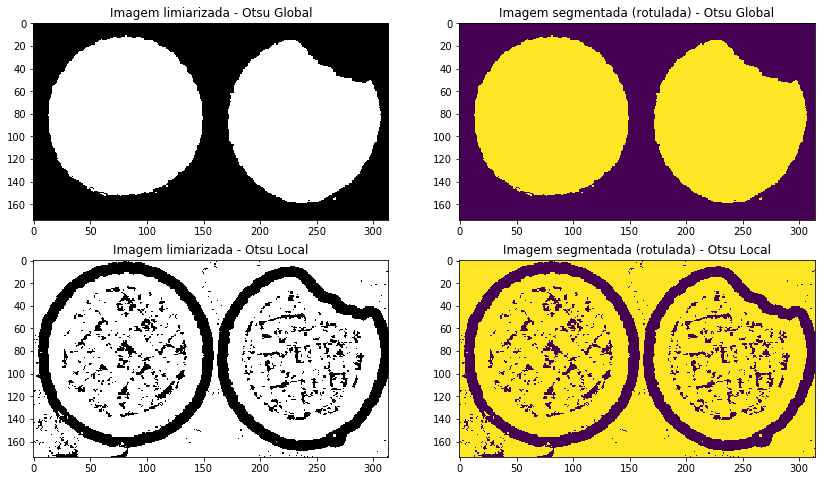

In [17]:
# Buscando um limiar ótimo para a segmentação, usando o algoritmo de Otsu (global)

t_glob_otsu = threshold_otsu(f) # t_glob_otsu é o limiar (escalar)
glob_otsu = (f >= t_glob_otsu)

# Buscando a segmentação, usando o algoritmo de Otsu (local) - limiares locais
# Neste caso é necessário escolher o tamanho da vizinhança que será usada na busca local

raio = 10
viz = mm.disk(raio)

t_loc_otsu = otsu(f, viz) # t_loc_otsu é uma imagem (um limiar para cada pixel)
loc_otsu = (f >= t_loc_otsu)

# Visualizando os resultados, como imagem binária e como imagem segmentada (rotulada)
plt.figure(1, figsize=(14,8))

plt.subplot(2,2,1)
plt.imshow(glob_otsu, cmap='gray')
plt.title('Imagem limiarizada - Otsu Global')
plt.subplot(2,2,2)
plt.imshow(glob_otsu)
plt.title('Imagem segmentada (rotulada) - Otsu Global')
plt.subplot(2,2,3)
plt.imshow(loc_otsu, cmap='gray')
plt.title('Imagem limiarizada - Otsu Local')
plt.subplot(2,2,4)
plt.imshow(loc_otsu)
plt.title('Imagem segmentada (rotulada) - Otsu Local')

### Segmentação pelo método de Watershed

Podemos resolver o mesmo problema de segmentação dos *cookies* aplicando agora o método de Watershed. A primeira tentativa seria usar o método de watershed e escolher os marcadores com a ajuda do histograma. Usaremos a função *watershed* da bilbioteca *skimage.segmentation*

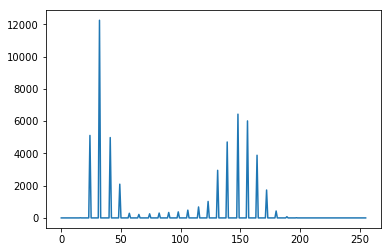

In [18]:
nbins = 256
hr, bin_edges = np.histogram(f, nbins,(0,255))
plt.plot(hr)

Os marcadores para *foreground* e *background* serão escolhidos como próximos aos 2 picos do histograma. Os valores não precisam ser exatos, pois não serão usados como limiar, apenas como semente.

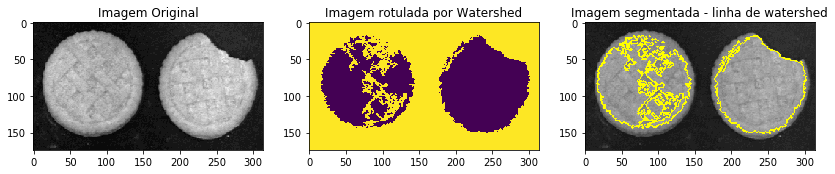

In [19]:
markers = np.zeros_like(f)
foreground, background = 1, 2 # rótulos para as sementes (objeto = 1 e fundo = 2)
markers[f < 30.0] = background # todos os pixels com valores <30 receberão o rótulo 2 na imagem markers
markers[f > 140.0] = foreground # todos os pixels com valores >140 receberão o rótulo 1 na imagem markers

# Cálculo do watershed a partir da imagem e dos marcadores
w1 = watershed(f, markers)
plt.figure(1, figsize=(14,8))

plt.subplot(1,3,1)
plt.imshow(f, cmap='gray')
plt.title('Imagem Original')
plt.subplot(1,3,2)
plt.imshow(w1)
plt.title('Imagem rotulada por Watershed')
plt.subplot(1,3,3)
plt.imshow(mark_boundaries(f,w1))
plt.title('Imagem segmentada - linha de watershed')

O resultado da segmentação obtido não foi satisfatório, pois usamos a imagem original como entrada do watersehd. Normalmente usa-se o gradiente da imagem como entrada (gradiente = descontinuidades). Usaremos nesse caso o detector de bordas de Sobel para obter este gradiente e depois rodaremos o algoritmo de watershed sobre este gradiente.

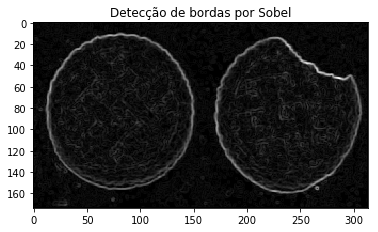

In [20]:
s = sobel(f)
plt.imshow(s,cmap='gray')
plt.title('Detecção de bordas por Sobel')

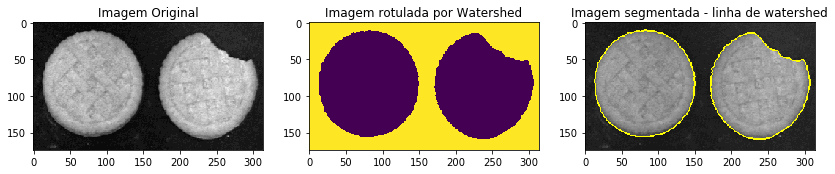

In [21]:
w2 = watershed(s,markers)
plt.figure(1, figsize=(14,8))

plt.subplot(1,3,1)
plt.imshow(f, cmap='gray')
plt.title('Imagem Original')
plt.subplot(1,3,2)
plt.imshow(w2)
plt.title('Imagem rotulada por Watershed')
plt.subplot(1,3,3)
plt.imshow(mark_boundaries(f,w2))
plt.title('Imagem segmentada - linha de watershed')

O resultado obtido agora com a segmentação parece muito mais próximo do desejado. Para terminar, vamos comparar os resultados das 2 segmentações - por *Otsu* e por *Watershed*  - e verificar qual similares elas são. Podemos fazer esta comparação de duas formas: qualitativa e quantitativa. A comparação qualitativa normalmente é feita visualizando as segmentações lado-a-lado ou sobrepostas.

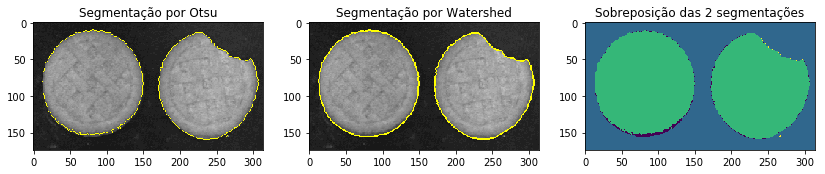

In [14]:
segj = join_segmentations(glob_otsu, w2)

plt.figure(1, figsize=(14,8))

plt.subplot(1,3,1)
plt.imshow(mark_boundaries(f,glob_otsu))
plt.title('Segmentação por Otsu')
plt.subplot(1,3,2)
plt.imshow(mark_boundaries(f,w2))
plt.title('Segmentação por Watershed')
plt.subplot(1,3,3)
plt.imshow(segj)
plt.title('Sobreposição das 2 segmentações')